In [1]:
import DiffusionBridge as db
import torch
import numpy as np
import argparse
from pathlib import Path
import time
from rich.panel import Panel
from rich.pretty import Pretty
from rich.console import Console
from rich.progress import Progress, SpinnerColumn, TimeElapsedColumn

from utils.data import gaussian, two_gaussian
from utils.plot import plot_bridge
from matplotlib import pyplot as plt
from easydict import EasyDict as edict

In [2]:
args = edict({'task': 'gaussian2twogaussian',
 'seed': 233,
 'checkpoint_score':
 'score_transition_net.pt',
 'checkpoint_marginal': None,
 'scheduler': None,
 'num_workers': 0,
 'lr': 0.01,
 'batch_size_tran': 5000,
 'batch_size_marg': 1000,
 'iters_tran': 500,
 'iters_marg': 100,
 'device': 'cuda',
 'debug': False,
 'log_dir': Path('experiments/debug')
 })

In [11]:
# problem settings
d = 1
sigma = torch.tensor(1.0)
T = torch.tensor(1.0)
M = 1000

# f For Schrodinger Bridge
def f(x, t): return 0

diffusion = db.diffusion.model(f, sigma, d, T, M)

sigma = 1
epsilon = 0.001
T = 1

source_dist = gaussian()
target_dist = two_gaussian(mu1=10, mu2=-10)
############################ Model ########################################
epsilon = 1e-3
ema_momentum = 0.99
output = diffusion.load_checkpoint_score(args.checkpoint_score)
score_transition_net = output['net']


score_transition_net = score_transition_net.cpu()

In [32]:
def gradient_transition(trajectories, scaled_brownian, epsilon):
    N = trajectories.shape[0]
    M = diffusion.num_steps
    grad = torch.zeros(N, M, diffusion.d)
    X0 = trajectories[:, 0, :] 

    for m in range(M):
        X_next = trajectories[:, m+1, :]
        if (m == (M-1)):
            # fudging a little here because of singularity                
            t_next = diffusion.time[m+1] - 0.25 * diffusion.stepsizes[m]
        else: 
            t_next = diffusion.time[m+1]
        grad[:, m, :] = scaled_brownian[:, m, :] # - epsilon * diffusion.invSigma * (X0 - X_next) / (diffusion.T - t_next)

    return grad


def gradient_marginal(trajectories, scaled_brownian, epsilon):
    N = trajectories.shape[0]
    M = diffusion.num_steps
    grad = torch.zeros(N, M, diffusion.d)
    XT = trajectories[:, M, :] 

    for m in range(M,0,-1):
        Z_next = trajectories[:, m-1, :,]
        if (m == 1):
            # fudging a little here because of singularity                
            t_next = 0.25 * diffusion.stepsizes[m-1]
        else: 
            t_next = diffusion.time[m-1]
        grad[:, m-1, :] = scaled_brownian[:, m-1, :] - epsilon * diffusion.invSigma * (XT - Z_next) / t_next
    return grad

In [33]:
def simulate_bridge_backwards_true(score_net, initial_state, terminal_state, epsilon, num_samples = 1, modify = False, full_score = False, new_num_steps = None):
    # initialize and preallocate
    if len(initial_state.shape) == 1:
        X0 = initial_state.repeat(num_samples, 1) # size (N, d)
        N = num_samples
    else:
        X0 = initial_state.clone() 
        N = initial_state.shape[0]        
    
    if len(terminal_state.shape) == 1:
        Z = terminal_state.repeat(num_samples, 1) # size (N, d)
        N = num_samples
    else:
        Z = terminal_state.clone()
        N = terminal_state.shape[0]        
    

    M = diffusion.num_steps
    timesteps = diffusion.time
    stepsizes = diffusion.stepsizes


    trajectories = torch.zeros(N, M+1, diffusion.d)
    trajectories[:, M, :] = Z
    scaled_brownian = torch.zeros(N, M, diffusion.d)
    score_evaluations = torch.zeros(N, M, diffusion.d)


    simulation_output = diffusion.simulate_process(X0)
    
    score_transition_all = diffusion.gradient_transition(simulation_output['trajectories'], simulation_output['scaled_brownian'], epsilon)

    # simulate process backwards in time
    for m in range(M, 0, -1):
        stepsize = stepsizes[m-1]
        t = timesteps[m]
        t_next = timesteps[m-1]
        if full_score:
            score = score_transition_all[:,m-1,:]
        else:
            score = score_net(t.repeat((N,1)), Z) # size (N, d)
        if diffusion.debug:
            print(score.shape)
        score_evaluations[:, m-1, :] = score
        drift = -diffusion.f(t,Z) + diffusion.Sigma * score + epsilon * (X0 - Z) / t
        euler = Z + stepsize * drift
        if (m > 1):
            if modify:
                scaling = stepsize * t_next / t
            else:
                scaling = stepsize
            brownian = torch.sqrt(scaling) * torch.randn(Z.shape) # size (N x d)
            Z = euler + diffusion.sigma * brownian
            trajectories[:, m-1, :] = Z
            scaled_brownian[:, m-1, :] = - (diffusion.invSigma / scaling) * diffusion.sigma * brownian
        else:
            # terminal constraint
            if modify:
                # fudging a little here because of singularity
                scaling = stepsize * 0.25 * stepsize / t
            else:
                scaling = stepsize
            trajectories[:, 0, :] = X0
            scaled_brownian[:, 0, :] = - (diffusion.invSigma / scaling) * (X0 - euler)

    # output
    output = {'trajectories' : trajectories, 'scaled_brownian' : scaled_brownian, 'score_evaluations' : score_evaluations}
    
    return output

In [34]:
def my_simulate_bridge_forwards_true(score_transition_net, score_marginal_net, initial_state, terminal_state, epsilon, num_samples = 1, modify = False, full_score = False, new_num_steps = None):
    # initialize and preallocate
    T = diffusion.T
    if len(initial_state.shape) == 1:
        X0 = initial_state.repeat(num_samples, 1) # size (N, d)
        X = initial_state.repeat(num_samples, 1) # size (N, d)
        N = num_samples
    else:
        X0 = initial_state.clone()
        X = initial_state.clone() 
        N = initial_state.shape[0]        
    
    if len(terminal_state.shape) == 1:
        XT = terminal_state.repeat(num_samples, 1) # size (N, d)
        N = num_samples
    else:
        XT = terminal_state.clone()
        N = terminal_state.shape[0]

    M = diffusion.num_steps
    timesteps = diffusion.time
    stepsizes = diffusion.stepsizes

    trajectories = torch.zeros(N, M+1, diffusion.d)
    trajectories[:, 0, :] = X
    
    with torch.no_grad():
        simulation_output = diffusion.my_simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, num_samples, modify = True, full_score = True)

    score_marginal_all = diffusion.gradient_marginal(simulation_output['trajectories'], simulation_output['scaled_brownian'], epsilon)
    
    # simulate process forwards in time
    for m in range(M-1):
        stepsize = stepsizes[m]
        if m == 0:
            # fudging a little here because of singularity                
            t = timesteps[m] + 0.5 * stepsize 
        else: 
            t = timesteps[m]
        t_next = timesteps[m+1]
        if full_score:
            # score_marginal = score_marginal_net(t.repeat(N,1), X) # size (N, d)
            score_marginal = score_marginal_all[:, m, :]
            score_transition = score_transition_net(t.repeat(N,1), X, X0) # size (N, d)
        else:    
            score_marginal = score_marginal_net(t.repeat(N,1), X) # size (N, d)
            score_transition = score_transition_net(t.repeat(N,1), X) # size (N, d)
        drift = diffusion.Sigma * (score_marginal - score_transition) #+ epsilon * ((XT - X) / (T - t) - (X0 - X) / t) #+ diffusion.f(t, X)
        euler = X + stepsize * drift
        if modify:
            scaling = stepsize * (T - t_next) / (T - t)
        else:
            scaling = stepsize            
        brownian = torch.sqrt(scaling) * torch.randn(X.shape) # size (N x d)
        X = euler + diffusion.sigma * brownian
        trajectories[:, m+1, :] = X

    # terminal constraint
    trajectories[:, M, :] = XT

    # output
    output = {'trajectories': trajectories}

    return output

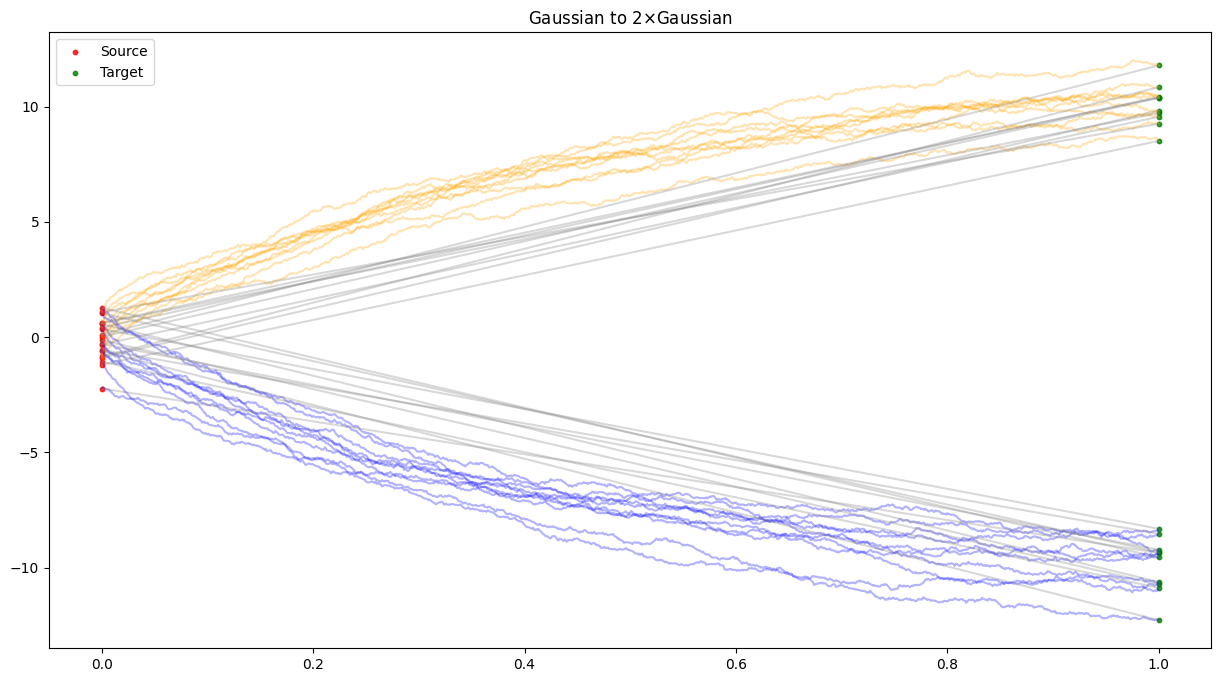

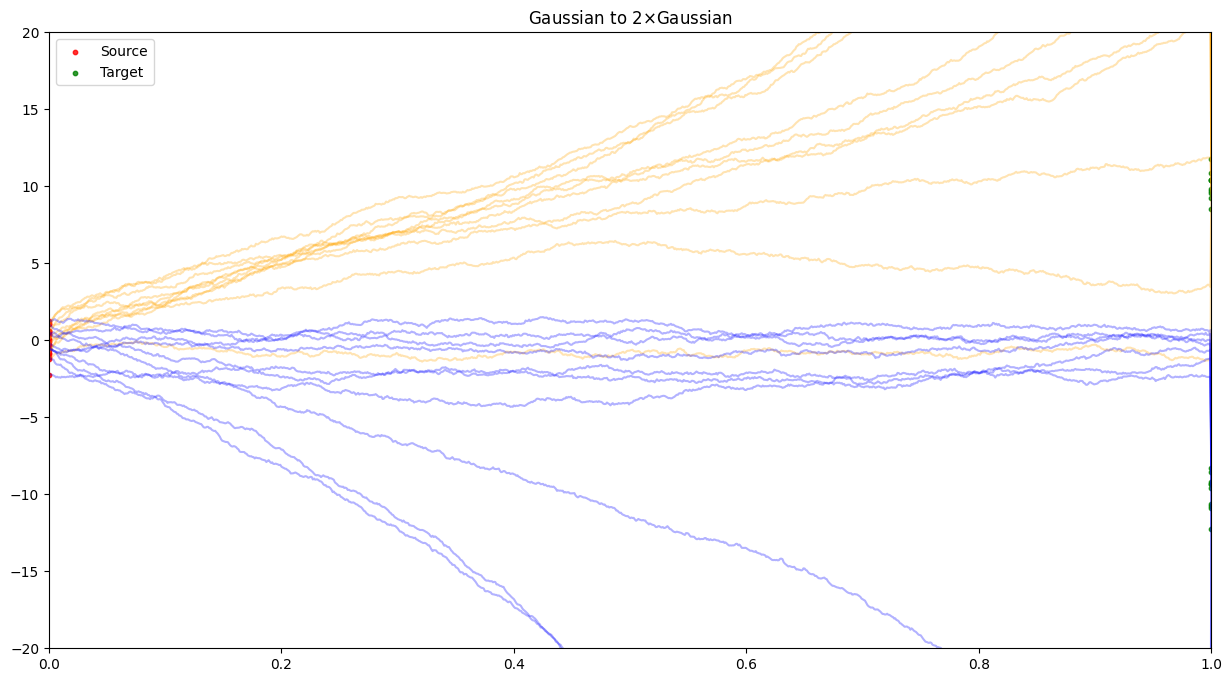

In [37]:
############################# Test ########################################
num_test_samples = 20
source_sample = source_dist(num_test_samples)
target_sample = target_dist(num_test_samples)

out = diffusion.my_simulate_bridge_backwards(
    score_transition_net, source_sample, target_sample, 0, modify=True, full_score=True)
fig, _ = plot_bridge(diffusion.time.numpy(), out['trajectories'][:, :, 0].detach(
).numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=True)
fig.savefig(args.log_dir / 'bridge_backward.jpg')

out = my_simulate_bridge_forwards_true(score_transition_net, None, source_sample,
                                            target_sample, 0, num_samples=1, modify=False, full_score=True, new_num_steps=None)
fig, ax = plot_bridge(diffusion.time.numpy(), out['trajectories'][:, :, 0].detach(
).numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=False)
ax.set_xlim(0, 1)
ax.set_ylim(-20, 20)
fig.show()
fig.savefig(args.log_dir / 'bridge_forward.jpg')

# out = diffusion.my_simulate_process(source_sample, target_sample)
# fig, _ = plot_bridge(diffusion.time.numpy(), out['trajectories'][:, :, 0].detach(
# ).numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=False)
# fig.savefig(args.log_dir / 'bridge_real.jpg')